<a href="https://colab.research.google.com/github/Deepak-Mewada/VisionLLM/blob/main/VLM_from_scratch_for_geometry_shapes_%5BFINAL%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [ ]:
# @title
import math, random, io
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

##Constants

In [ ]:
# @title
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 32
EMBED_DIM = 3
BATCH_SIZE = 12
EPOCHS = 50
LR = 3e-4
TEMPERATURE = 0.07
ATTENTION_HEADS = 3

##Synthetic dataset shapes

In [ ]:
# @title
colors = ['red','green','blue','yellow','purple','orange', 'pink', 'brown', 'gray']
shapes = ['square','circle','triangle']
positions = ['left','center','right', 'top', 'bottom', 'top-left', 'top-right', 'bottom-left', 'bottom-right']

##Image draw function

In [ ]:
# @title
def draw_sample(color, shape, position, img_size=IMG_SIZE):
    img = Image.new('RGB', (img_size, img_size), 'white')
    draw = ImageDraw.Draw(img)
    margin = 6
    w = h = img_size - 2*margin

    # Calculate x coordinates
    if 'left' in position:
        x0 = margin
        x1 = margin + w // 2
    elif 'top-left' in position:
        x0 = margin
        x1 = margin + w // 2
    elif 'bottom-left' in position:
        x0 = margin
        x1 = margin + w // 2
    elif 'right' in position:
        x0 = margin + w // 2
        x1 = img_size - margin
    elif 'top-right' in position:
        x0 = margin + w // 2
        x1 = img_size - margin
    elif 'bottom-right' in position:
        x0 = margin + w // 2
        x1 = img_size - margin
    else: # center or vertical positions
        x0 = margin + w // 4
        x1 = margin + 3 * w // 4

    # Calculate y coordinates
    if 'top' in position:
        y0 = margin
        y1 = margin + h // 2
    elif 'top-left' in position:
        y0 = margin
        y1 = margin + h // 2
    elif 'top-right' in position:
        y0 = margin
        y1 = margin + h // 2
    elif 'bottom' in position:
        y0 = margin + h // 2
        y1 = img_size - margin
    elif 'bottom-left' in position:
        y0 = margin + h // 2
        y1 = img_size - margin
    elif 'bottom-right' in position:
        y0 = margin + h // 2
        y1 = img_size - margin
    else: # center or horizontal positions
        y0 = margin + h // 4
        y1 = margin + 3 * h // 4

    if shape=='square':
        draw.rectangle([x0,y0,x1,y1], fill=color, outline='black')
    elif shape=='circle':
        draw.ellipse([x0,y0,x1,y1], fill=color, outline='black')
    else:  # triangle
        draw.polygon([((x1+x0)//2, y0), (x0, y1), (x1, y1)], fill=color, outline='black')
    return img

##Class for building the Dataset - Images and Captions

In [ ]:
# @title
class ShapesDataset():
    def __init__(self):
        self.images = []
        self.captions = []

        # Generate all possible triplets
        for c in colors:
            for s in shapes:
                for p in positions:
                    img = draw_sample(c, s, p) #image
                    cap = f"{c} {s} {p}" #corresponding caption
                    self.images.append(torch.from_numpy(np.asarray(img)).permute(2,0,1).float()/255.0)
                    self.captions.append(cap)
        self.vocab, self.word2idx = self.build_vocab(self.captions)

    def build_vocab(self, texts):
        words = sorted({w for t in texts for w in t.split()})
        vocab = ['[CLS]'] + words
        w2i = {w:i for i,w in enumerate(vocab)}
        return vocab, w2i

    def encode_text(self, text):
        toks = [self.word2idx['[CLS]']] + [self.word2idx[w] for w in text.split()]
        return torch.tensor(toks, dtype=torch.long)

    def __len__(self): return len(self.images)

    def __getitem__(self, i):
        return self.images[i], self.encode_text(self.captions[i]), self.captions[i]

# Create the full dataset
full_ds = ShapesDataset()
VOCAB_SIZE = len(full_ds.vocab)

##Train-Val split

In [ ]:
# @title
train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])

##Data Loaders

In [ ]:
# @title
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

##Display a random sample image

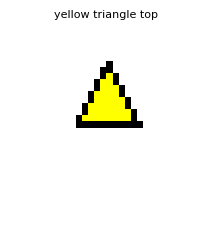

In [ ]:
# @title
imgs, _, caps = next(iter(train_loader))
idx = random.randint(0, len(imgs) - 1)
img = (imgs[idx].permute(1, 2, 0).numpy() * 255).astype(np.uint8) # Convert to displayable image

plt.figure(figsize=(2.5, 2.5))
plt.imshow(img)
plt.title(caps[idx], fontsize=8)
plt.axis('off')
plt.show()

##Image encoder

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,3,2,1), nn.ReLU(),
            nn.Conv2d(32,64,3,2,1), nn.ReLU(),
            nn.Conv2d(64,128,3,2,1), nn.ReLU(),
            nn.Conv2d(128,256,3,2,1), nn.ReLU()
        )
        self.proj = nn.Linear(256, embed_dim)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.conv(x)                      # N x C x H x W
        x = x.mean(dim=[2,3])                 # global average pool → N x C
        x = self.proj(x)                      # N x D
        x = F.normalize(self.norm(x), dim=-1) # unit norm embeddings
        return x

##Text encoder with attention

In [ ]:
# @title
class TextEncoder(nn.Module):
    def __init__(self, vocab_size = VOCAB_SIZE, embed_dim=EMBED_DIM, max_len=4, num_heads=ATTENTION_HEADS):
        super().__init__()
        self.tok = nn.Embedding(vocab_size, embed_dim)
        self.pos = nn.Embedding(max_len, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.norm = nn.LayerNorm(embed_dim)
        self.max_len = max_len

    def forward(self, toks):
        N, L = toks.shape
        pos_ids = torch.arange(L, device=toks.device).unsqueeze(0).expand(N, L)
        x = self.tok(toks) + self.pos(pos_ids)
        x = self.attn(x, x, x)[0]
        x = x[:, 0]
        x = self.proj(x)
        x = F.normalize(self.norm(x), dim=-1)
        return x

##Text encoder without attention

In [ ]:
# class TextEncoder(nn.Module):
#     def __init__(self, vocab_size, embed_dim=EMBED_DIM, max_len=4):
#         super().__init__()
#         self.tok = nn.Embedding(vocab_size, embed_dim)
#         self.pos = nn.Embedding(max_len, embed_dim)
#         self.proj = nn.Linear(embed_dim, embed_dim)
#         self.norm = nn.LayerNorm(embed_dim)
#         self.max_len = max_len

#     def forward(self, toks):
#         N, L = toks.shape
#         pos_ids = torch.arange(L, device=toks.device).unsqueeze(0).expand(N, L)
#         x = self.tok(toks) + self.pos(pos_ids)
#         x = x.mean(dim=1)                     # simple mean pool
#         x = self.proj(x)
#         x = F.normalize(self.norm(x), dim=-1)
#         return x

##CLIP like loss

In [ ]:
# @title
def clip_loss(img_emb, txt_emb, temperature=TEMPERATURE):
    logits = img_emb @ txt_emb.t() / temperature          # N x N
    targets = torch.arange(img_emb.size(0), device=img_emb.device)
    loss_i = F.cross_entropy(logits, targets)
    loss_t = F.cross_entropy(logits.t(), targets)
    return (loss_i + loss_t) / 2.0

##Model, data, optimizer


In [ ]:
# @title
VOCAB_SIZE = len(full_ds.vocab)
img_enc = ImageEncoder().to(device)
txt_enc = TextEncoder(VOCAB_SIZE).to(device)
params = list(img_enc.parameters()) + list(txt_enc.parameters())
opt = torch.optim.AdamW(params, lr=LR)

##Display embeddings before training

In [ ]:
def show_image(t, title=None):
    img = (t.permute(1,2,0).numpy()*255).astype(np.uint8)
    plt.figure(figsize=(2.2,2.2))
    plt.axis('off')
    if title: plt.title(title, fontsize=8)
    plt.imshow(img); plt.show()

Sample image and caption for embeddings visualization: 'pink square top-right'


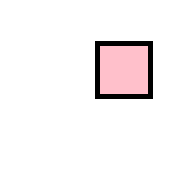

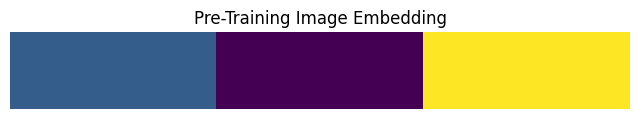

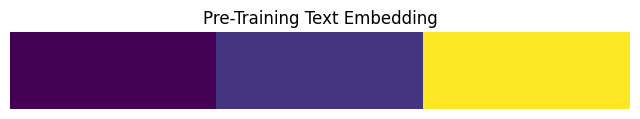

In [ ]:
# @title
img_enc.eval(); txt_enc.eval()

with torch.no_grad():
    # Select a random index
    random_idx = random.randrange(len(full_ds))
    sample_img, sample_toks, sample_cap = full_ds[random_idx]
    sample_img = sample_img.unsqueeze(0).to(device)
    sample_toks = sample_toks.unsqueeze(0).to(device)
    pre_train_img_emb = img_enc(sample_img).squeeze(0).cpu().numpy()
    pre_train_txt_emb = txt_enc(sample_toks).squeeze(0).cpu().numpy()

# Display the sample image and caption
print(f"Sample image and caption for embeddings visualization: '{sample_cap}'")
show_image(sample_img.squeeze(0).cpu())

# Function to visualize embeddings (simplified)
def plot_embedding(embedding, title):
    plt.figure(figsize=(8, 1))
    plt.imshow(embedding.reshape(1, -1), aspect='auto', cmap='viridis')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_embedding(pre_train_img_emb, "Pre-Training Image Embedding")
plot_embedding(pre_train_txt_emb, "Pre-Training Text Embedding")

##Training loop

In [ ]:
# @title
best_val = float('inf')

for epoch in range(1, EPOCHS+1):
    img_enc.train(); txt_enc.train()
    total = 0.0

    for imgs, toks, _ in train_loader:
        imgs = imgs.to(device); toks = toks.to(device)
        opt.zero_grad(set_to_none=True)
        ie = img_enc(imgs); te = txt_enc(toks)
        loss = clip_loss(ie, te)
        loss.backward()
        opt.step()
        total += loss.item()*imgs.size(0)
    train_loss = total / (len(train_loader)*BATCH_SIZE)

    # quick val
    img_enc.eval(); txt_enc.eval()
    with torch.no_grad():
        vtotal, n = 0.0, 0
        for imgs, toks, _ in val_loader:
            imgs = imgs.to(device); toks = toks.to(device)
            vtotal += clip_loss(img_enc(imgs), txt_enc(toks)).item()*imgs.size(0)
            n += imgs.size(0)
        val_loss = vtotal / n

    print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")
    best_val = min(best_val, val_loss)

Epoch 01 | train 4.0528 | val 4.0915
Epoch 02 | train 3.8787 | val 3.9032
Epoch 03 | train 3.5367 | val 3.6918
Epoch 04 | train 3.3835 | val 3.5645
Epoch 05 | train 2.9640 | val 3.4319
Epoch 06 | train 2.5705 | val 2.9575
Epoch 07 | train 2.2374 | val 3.5916
Epoch 08 | train 2.1499 | val 2.5411
Epoch 09 | train 1.8224 | val 2.3828
Epoch 10 | train 1.6382 | val 2.5208
Epoch 11 | train 1.6518 | val 2.3562
Epoch 12 | train 1.6524 | val 2.2789
Epoch 13 | train 1.4986 | val 2.1317
Epoch 14 | train 1.4827 | val 2.3231
Epoch 15 | train 1.4662 | val 2.0513
Epoch 16 | train 1.4275 | val 2.0636
Epoch 17 | train 1.3291 | val 1.8985
Epoch 18 | train 1.3764 | val 1.9907
Epoch 19 | train 1.3084 | val 1.9076
Epoch 20 | train 1.3018 | val 2.0215
Epoch 21 | train 1.2737 | val 1.8944
Epoch 22 | train 1.2959 | val 1.9289
Epoch 23 | train 1.2934 | val 2.0634
Epoch 24 | train 1.3810 | val 1.9256
Epoch 25 | train 1.3792 | val 2.0726
Epoch 26 | train 1.2403 | val 1.9777
Epoch 27 | train 1.2414 | val 1.9841
E

###Display embeddings after training

Sample image and caption for embeddings visualization: 'pink square top-right'


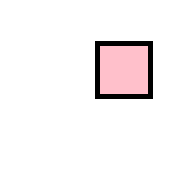

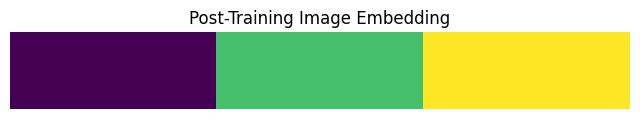

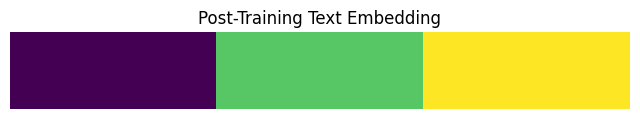

In [ ]:
# @title
img_enc.eval(); txt_enc.eval()
with torch.no_grad():
    # Use the same random index as before training
    sample_img, sample_toks, sample_cap = full_ds[random_idx]
    sample_img = sample_img.unsqueeze(0).to(device)
    sample_toks = sample_toks.unsqueeze(0).to(device)

    post_train_img_emb = img_enc(sample_img).squeeze(0).cpu().numpy()
    post_train_txt_emb = txt_enc(sample_toks).squeeze(0).cpu().numpy()

# Display the sample image and caption
print(f"Sample image and caption for embeddings visualization: '{sample_cap}'")
show_image(sample_img.squeeze(0).cpu())

plot_embedding(post_train_img_emb, "Post-Training Image Embedding")
plot_embedding(post_train_txt_emb, "Post-Training Text Embedding")

In [ ]:
# @title
#Calculate and print dot products
print("\nDot product between image and text embeddings:")
print(f"  Before training: {np.dot(pre_train_img_emb, pre_train_txt_emb):.4f}")
print(f"  After training: {np.dot(post_train_img_emb, post_train_txt_emb):.4f}")


Dot product between image and text embeddings:
  Before training: 0.9081
  After training: 0.9993


##Build text bank for retrieval on val set

In [ ]:
# @title
img_enc.eval(); txt_enc.eval()
with torch.no_grad():
    val_imgs, val_toks, val_caps = [], [], []
    for imgs, toks, caps in val_loader:
        val_imgs.append(imgs); val_toks.append(toks); val_caps += list(caps)
    val_imgs = torch.cat(val_imgs).to(device)
    val_toks = torch.cat(val_toks).to(device)
    img_emb = img_enc(val_imgs)
    txt_emb = txt_enc(val_toks)

##Retrieval helper functions

In [ ]:
# @title
def topk_text_for_images(k=3, idxs=None):
    if idxs is None: idxs = np.random.choice(len(val_caps), size=1, replace=False)
    sims = (img_emb @ txt_emb.t()).softmax(dim=1)  # similarity as softmax
    for i in idxs:
        best = sims[i].topk(k).indices.tolist()
        print(f"\nImage {i} best captions:")
        for j in best:
            print("  -", val_caps[j])
        show_image(val_imgs[i].cpu())

def topk_images_for_text(k=3, idxs=None):
    if idxs is None: idxs = np.random.choice(len(val_caps), size=1, replace=False)
    sims = (txt_emb @ img_emb.t()).softmax(dim=1)
    for i in idxs:
        best = sims[i].topk(k).indices.tolist()
        print(f"\nText '{val_caps[i]}' best images:")
        for j in best:
            show_image(val_imgs[j].cpu(), title=f"match {val_caps[j]}")

##Demo: show a few image-to-text and text-to-image retrievals


Image 34 best captions:
  - brown triangle top-left


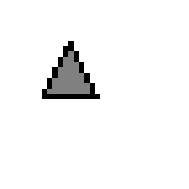


Text 'green square top-left' best images:


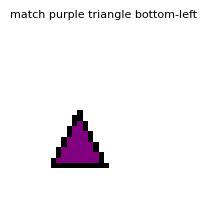

In [ ]:
# @title
topk_text_for_images(k=1)
topk_images_for_text(k=1)